In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets
from buscarpy import calculate_h0
from fastlite import *
from fastcore.utils import *
from fastcore.net import urlsave
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

## Get the latest data from the HPC

In [60]:
%%sh
bash sync.sh

In [33]:
# r = 'Appenzeller-Herzog_2019'
# table = pq.read_table(
#     '/p/tmp/maxcall/ml-screening/llm_preds', 
#     filters=[('review', '=', 'Appenzeller-Herzog_2019')]
# )

In [57]:
r = 'Appenzeller-Herzog_2019'
table = pq.read_table(
    'output_data/llm_preds', 
    #filters=[('review', '=', 'Appenzeller-Herzog_2019')]
    #filters=[('model'
)
table#.to_pandas().tail()#.py.unique()

pyarrow.Table
y: int64
py: float
pn: float
openalex_id: string
review: dictionary<values=string, indices=int32, ordered=0>
model: dictionary<values=string, indices=int32, ordered=0>
----
y: [[0,0,0,0,0,...,0,0,0,0,0]]
py: [[-0.88160884,0.1530062,-0.50191134,-0.7761283,-0.57062954,...,0.89329064,-0.43183333,-0.6918329,0.52741736,0.8198925]]
pn: [[0.9575441,0.97180057,0.9078738,0.951789,0.91489583,...,0.98969376,0.9711006,0.9183353,0.9874148,0.98638225]]
openalex_id: [["https://openalex.org/W2402226166","https://openalex.org/W2416808666","https://openalex.org/W2060266518","https://openalex.org/W2412464989","https://openalex.org/W66518910",...,"https://openalex.org/W2415222463","https://openalex.org/W2078451344","https://openalex.org/W2413863058","https://openalex.org/W2158367710","https://openalex.org/W2329275396"]]
review: [  -- dictionary:
["Appenzeller-Herzog_2019"]  -- indices:
[0,0,0,0,0,...,0,0,0,0,0]]
model: [  -- dictionary:
["meta-llama/Meta-Llama-3.1-8B-Instruct"]  -- indices:


0       1
1       1
2       0
3       0
4       0
       ..
2868    0
2869    0
2870    0
2871    0
2872    0
Name: y, Length: 2873, dtype: int64

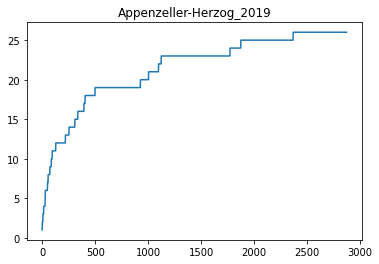

In [58]:
for r, group in table.to_pandas().groupby('review',observed=True):
    fig, ax = plt.subplots()
    ax.set_title(r)
    g = group.sort_values('py', ascending=False)['y'].reset_index(drop=True)
    ax.plot(g.cumsum())
g

In [59]:
group

,y,py,pn,review,model
openalex_id,,,,,
https://openalex.org/W2402226166,0,-0.881609,0.957544,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2416808666,0,0.153006,0.971801,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2060266518,0,-0.501911,0.907874,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2412464989,0,-0.776128,0.951789,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W66518910,0,-0.570630,0.914896,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
...,...,...,...,...,...
https://openalex.org/W2415222463,0,0.893291,0.989694,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2078451344,0,-0.431833,0.971101,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2413863058,0,-0.691833,0.918335,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct


## Database of SVM runs

In [2]:
dbpath = 'output_data/experiments_archive.sql'
dbpath = 'output_data/experiments.sql'
db = database(dbpath)
db.t

ordered_records, reviews, runs

In [3]:
db.t.ordered_records

<Table ordered_records (id, rec_id, screened_order, first_prediction, last_prediction, review_id, relevant, run_id)>

In [6]:
db.t.reviews

<Table reviews (review_id, review_name, n_records, prevalence)>

In [7]:
con = sqlite3.connect(dbpath)
df = pd.read_sql_query('SELECT * FROM reviews',con)
df

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [4]:
con = sqlite3.connect(dbpath)
df = pd.read_sql_query('SELECT * FROM runs',con)
df

,run_id,exp_started,version,thread
0,1,2024-08-06 11:42:31,0.0,69
1,2,2024-08-06 11:42:31,0.0,54
2,3,2024-08-06 11:42:31,0.0,17
3,4,2024-08-06 11:42:31,0.0,93
4,5,2024-08-06 11:42:31,0.0,51
...,...,...,...,...
95,96,2024-08-06 11:42:32,0.0,64
96,97,2024-08-06 11:42:32,0.0,21
97,98,2024-08-06 11:42:32,0.0,76
98,99,2024-08-06 11:42:32,0.0,52


In [5]:
stmt = '''
SELECT review_id ,
       Count(DISTINCT run_id) 
FROM   ordered_records
GROUP  BY review_id 
'''
df = pd.read_sql_query(stmt,con)
df

,review_id,Count(DISTINCT run_id)
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100
5,5,100
6,6,100
7,7,100
8,8,100
9,9,100


In [6]:
# version = '0.0.0'
# #stmt = f'SELECT orr.run_id,rec_id,screened_order,first_prediction,last_prediction,orr.review_id,reviews.review_name,relevant,thread FROM ordered_records orr LEFT JOIN runs ON orr.run_id=runs.run_id LEFT JOIN reviews ON orr.review_id=reviews.review_id WHERE version="{version}"'
# stmt = f'SELECT orr.run_id,rec_id,screened_order,first_prediction,last_prediction,orr.review_id,reviews.review_name,relevant,thread FROM ordered_records orr LEFT JOIN runs ON orr.run_id=runs.run_id LEFT JOIN reviews ON orr.review_id=reviews.review_id'
# #stmt = f'SELECT orr.run_id,rec_id,screened_order,orr.review,relevant,thread FROM ordered_records orr LEFT JOIN runs ON orr.run_id=runs.run_id WHERE version="{version}"'

# #stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
# df = pd.read_sql_query(stmt,con)
# print(df.shape)
# print(df.groupby('review_name')['thread'].nunique())
# df.head()


In [7]:
con = sqlite3.connect(dbpath)
rdf = pd.read_sql_query('SELECT * FROM reviews',con)

if rdf.shape[0]==0:
    reviews = db.t.reviews
    for rdf in iter_datasets():
        print(rdf.name)
        name = rdf.name
        labels = np.fromiter(rdf.labels.values(),dtype=int)
        rr = reviews.insert(
            review_name=rdf.name,
            n_records = labels.shape[0],
            prevalence = labels.sum()/labels.shape[0]
        )
    
rdf = pd.read_sql_query('SELECT * FROM reviews',con)
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


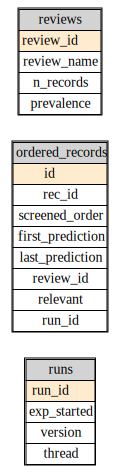

In [8]:
diagram(db.tables)


In [9]:
tdf = pd.DataFrame(
    {'a': [1,2,3], 'b': [1,2,3]}
)
tdf.to_parquet(
    'output_data/A_test',
    partition_cols=['a'],
    existing_data_behavior='delete_matching'
)

In [10]:
db_path = 'output_data/experiments.sql'
version='0.0'
rank=0
con = sqlite3.connect(db_path, timeout=120)
cur = con.cursor()
stmt = f'SELECT run_id FROM runs WHERE version="{version}" AND thread="{rank}";'
cur.execute(stmt)
res = cur.fetchone()
res
run_id = res[0]
run_id

39

In [11]:
tdf = pq.read_table('output_data/A_test')
tdf.to_pandas()

,b,a
0,1,1
1,2,2
2,3,3


In [10]:
# stmt = f'SELECT * FROM reviews'
# #stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
# reviews = pd.read_sql_query(stmt,con)
# reviews.head()

In [11]:
# for i, row in reviews.sort_values('n_records').reset_index().iterrows():
#     review_id = row['review_id']
#     rdf = df[df['review_id']==review_id]
#     for i, (name, group) in enumerate(rdf.groupby('thread')):
#         group = group.sort_values('screened_order').reset_index(drop=True)
#         stmt = f'SELECT n_screened, prediction FROM batch_predictions WHERE run_id="{rdf.run_id.values[0]}" AND review_id="{review_id}"'
#         preds = pd.read_sql_query(stmt,con).sort_values('n_screened').reset_index(drop=True)
#         for b, batch in preds.groupby('n_screened'):
#             pass
#         break
#     break
    
# group

In [12]:
# con = sqlite3.connect('output_data/experiments.sql')
# version = '0.0.0'
# stmt = f'SELECT * FROM batch_predictions'
# #stmt = 'SELECT * FROM ordered_records WHERE run_id=1'
# preds = pd.read_sql_query(stmt,con)
# preds

In [12]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

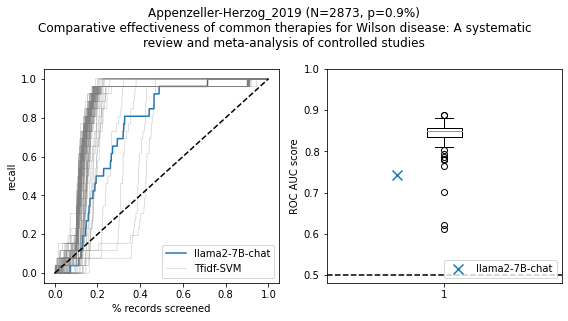

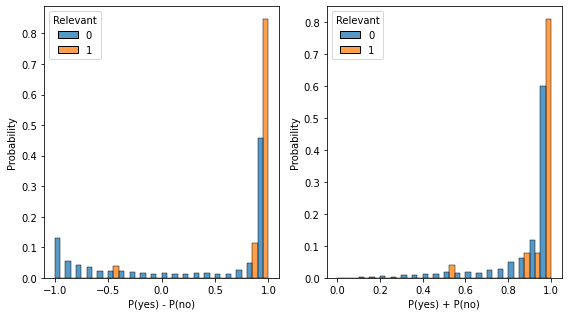

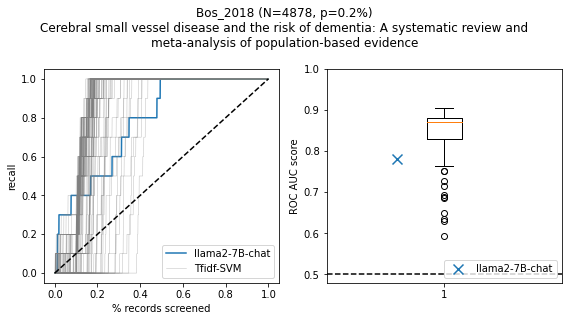

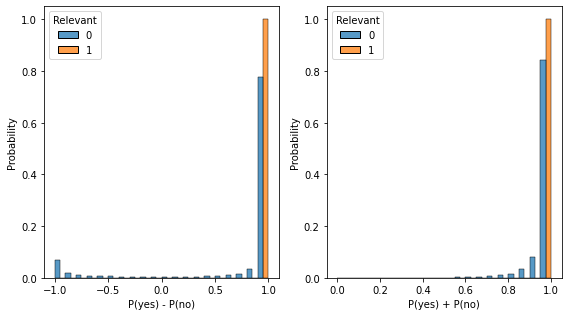

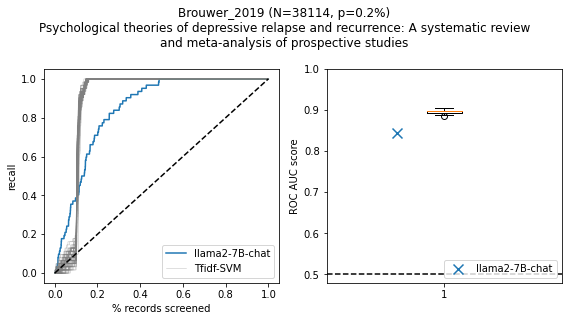

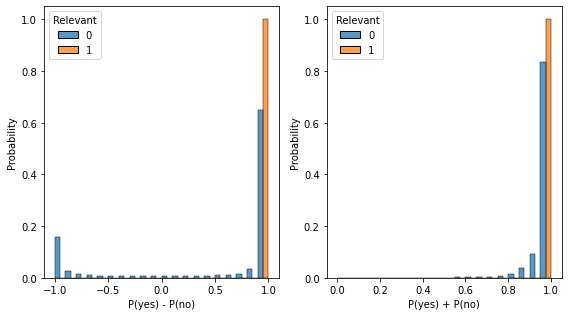

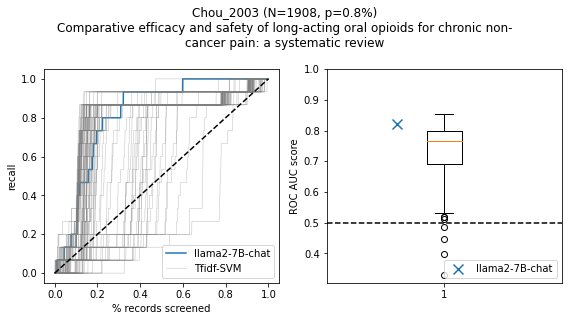

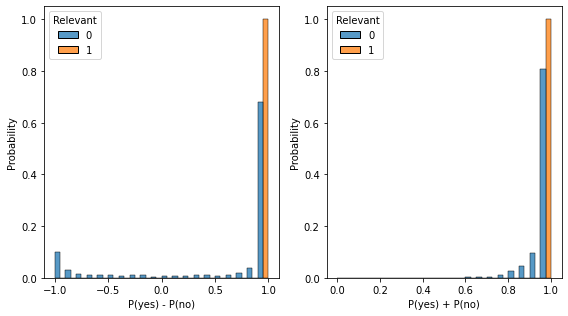

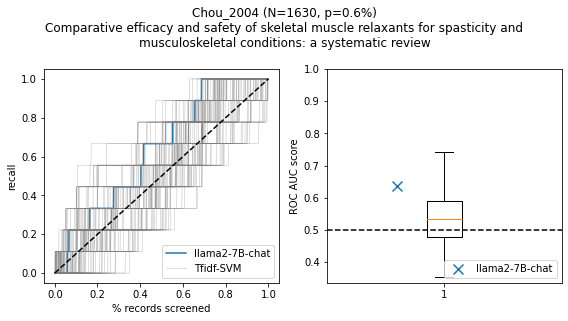

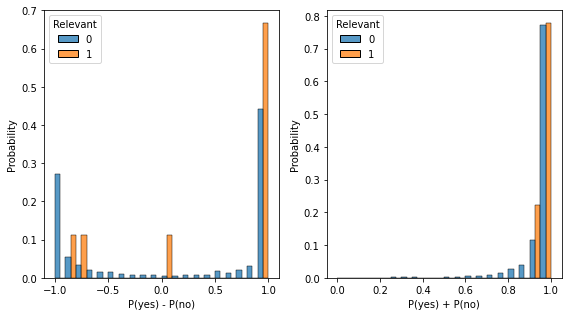

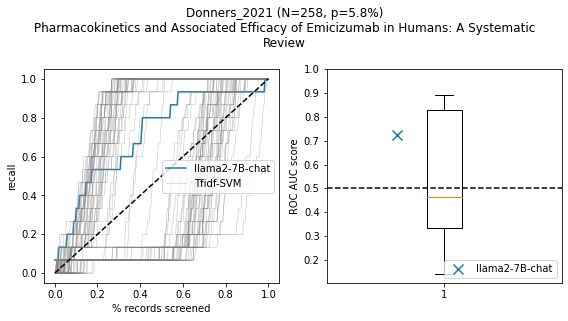

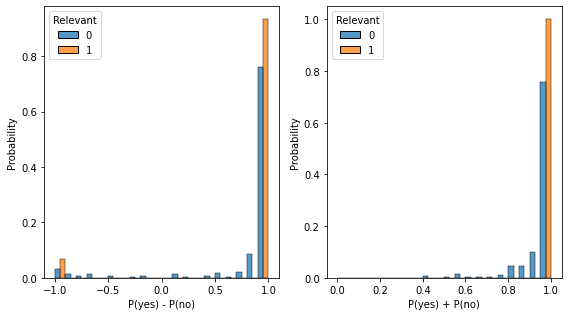

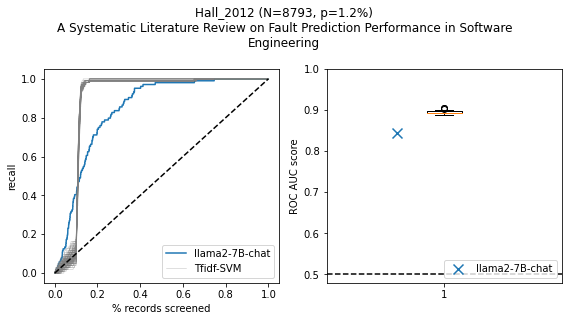

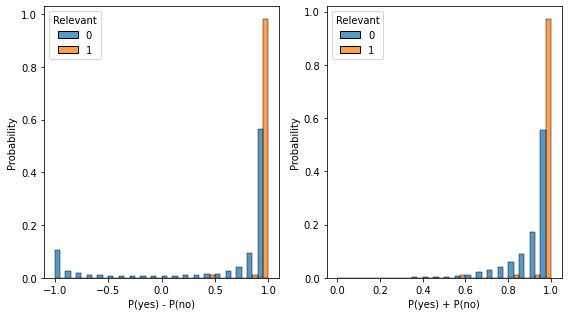

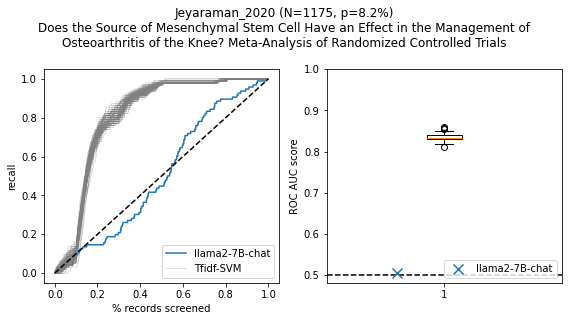

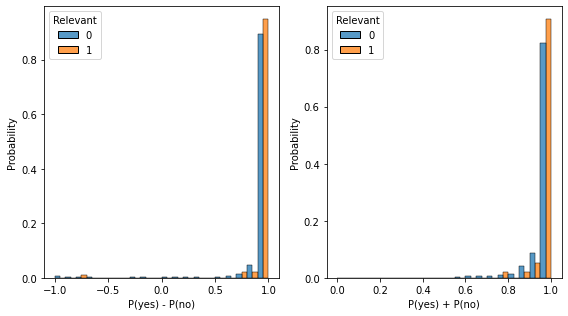

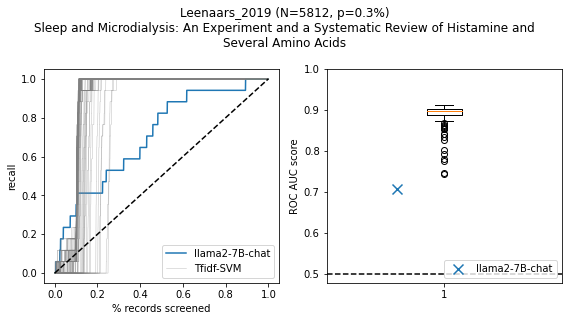

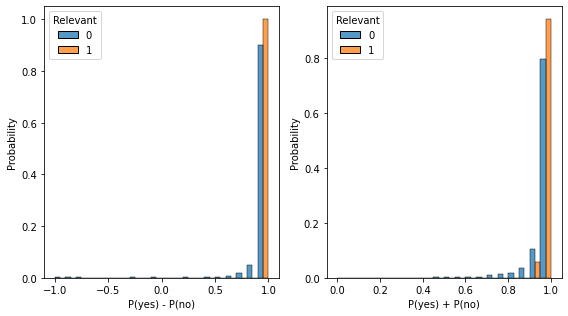

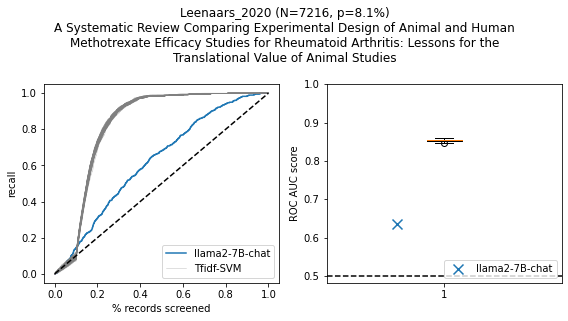

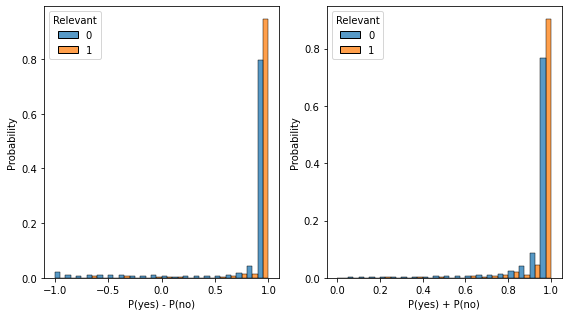

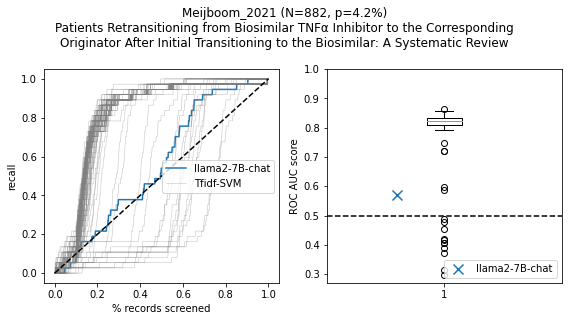

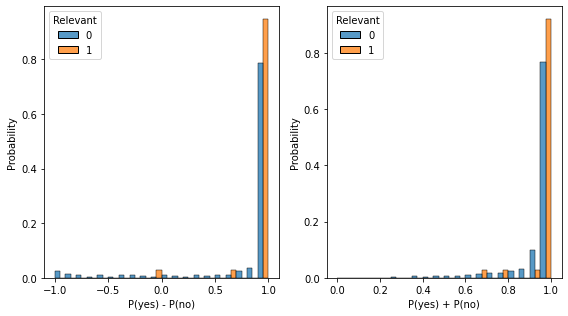

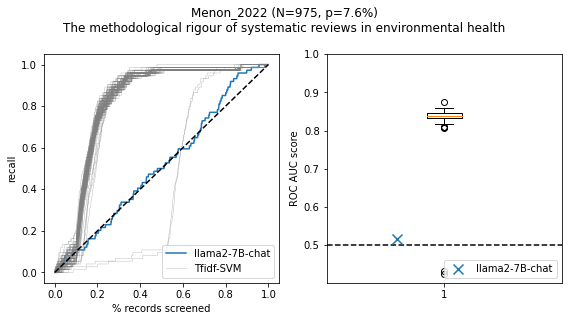

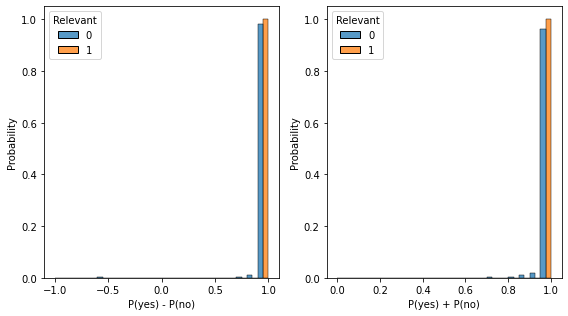

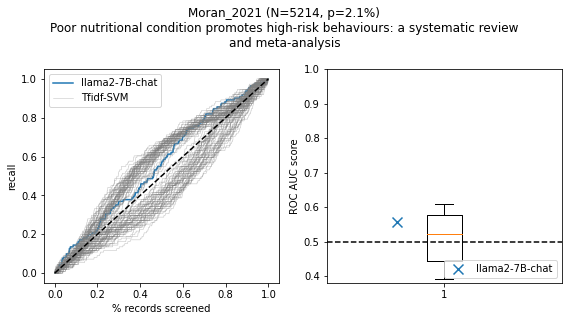

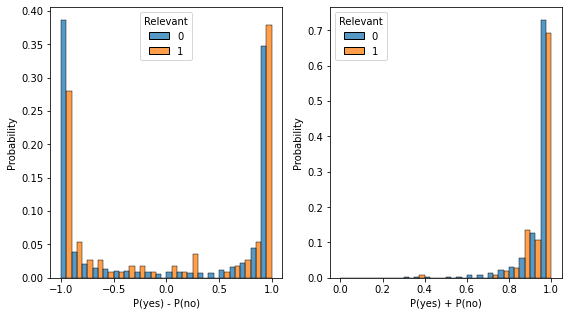

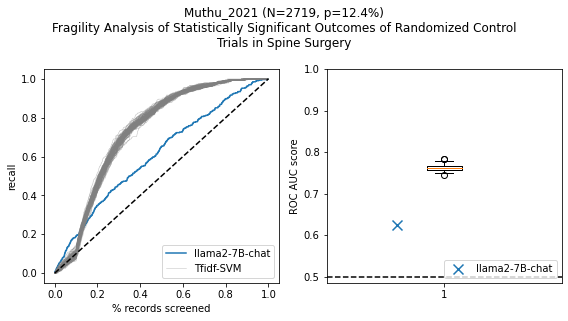

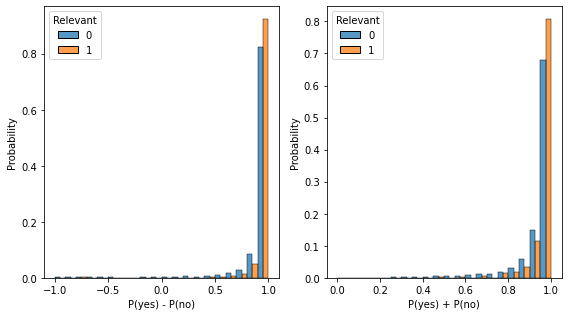

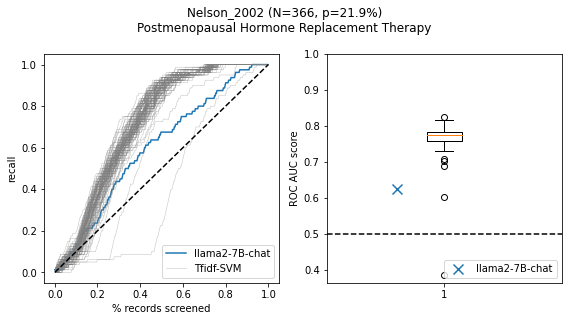

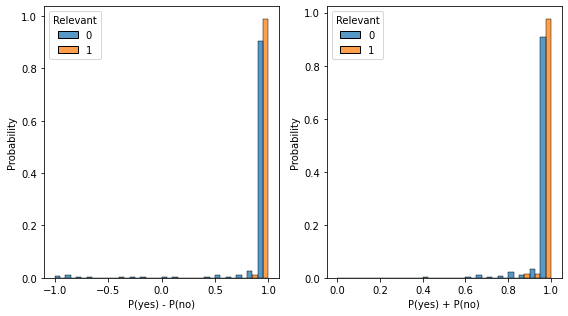

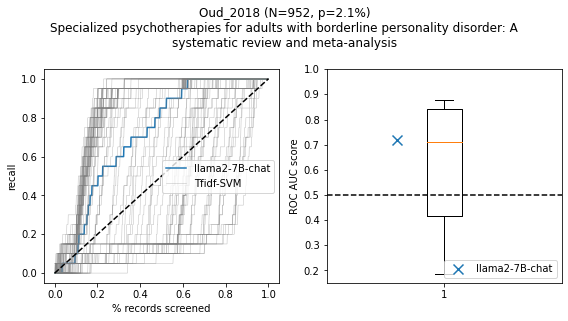

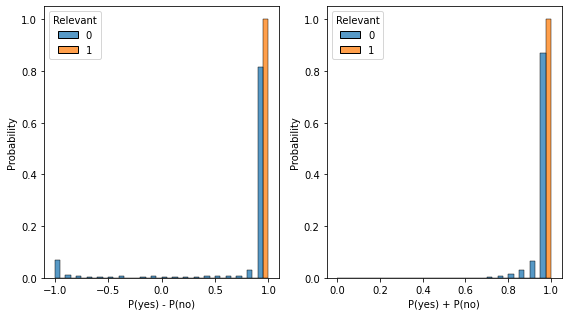

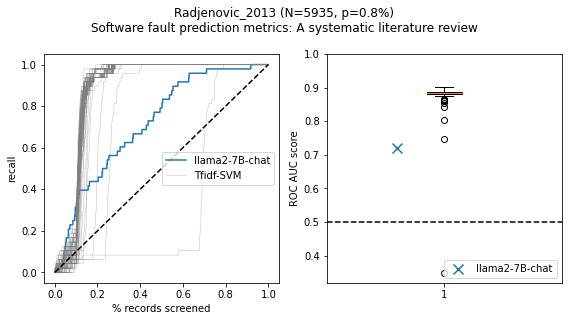

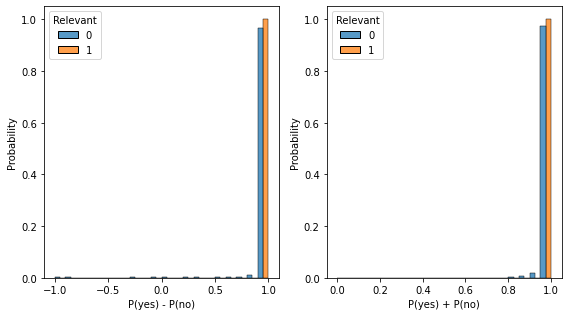

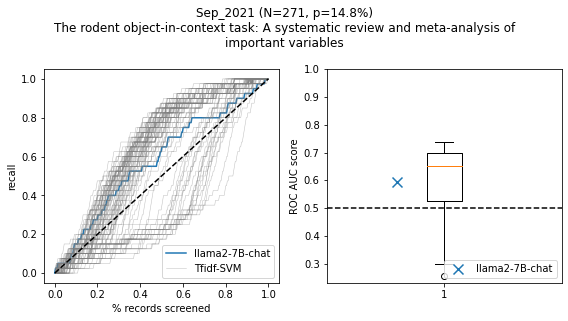

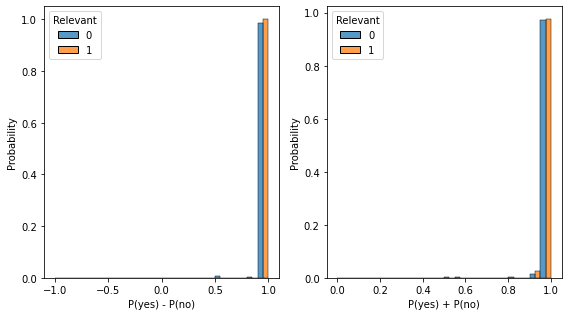

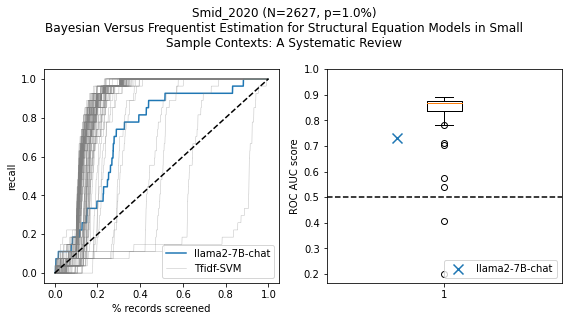

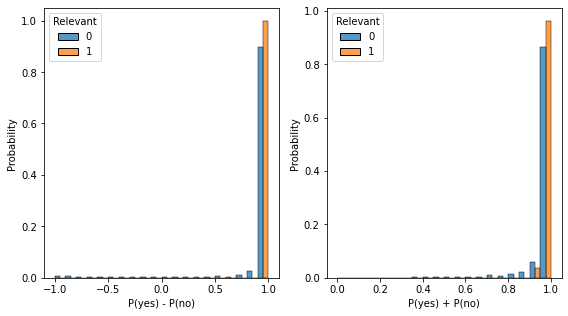

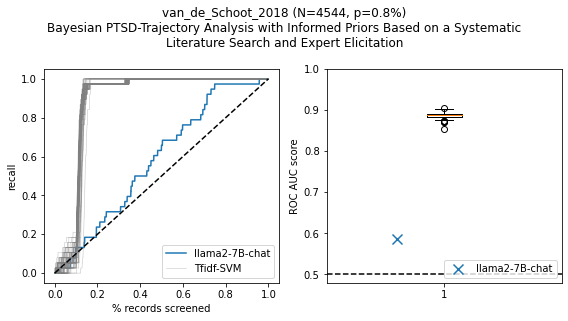

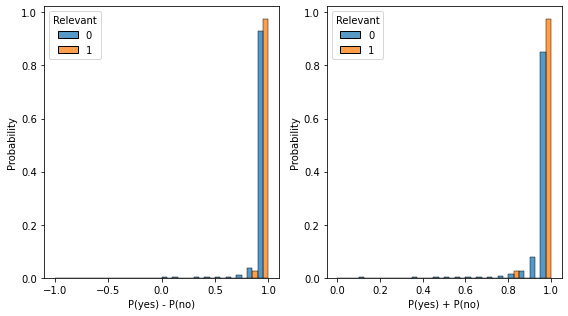

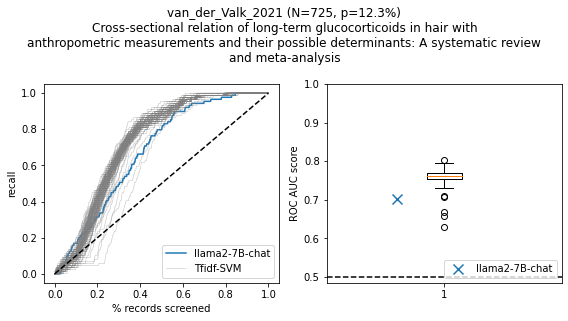

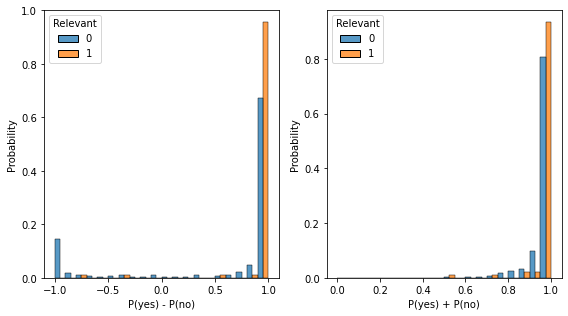

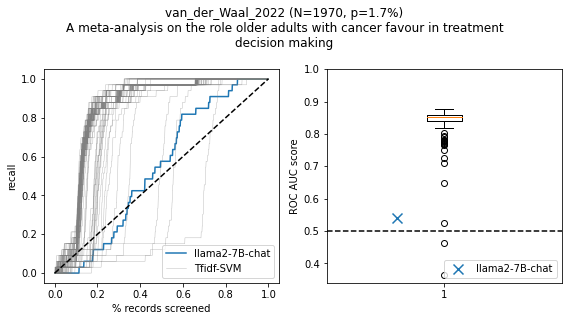

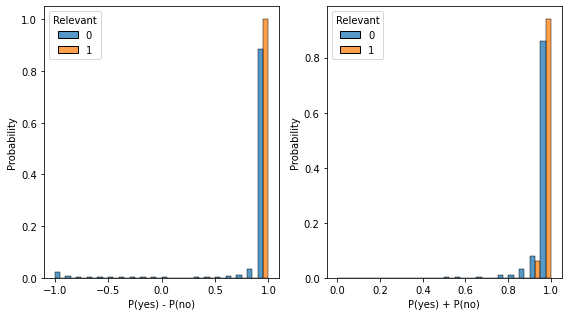

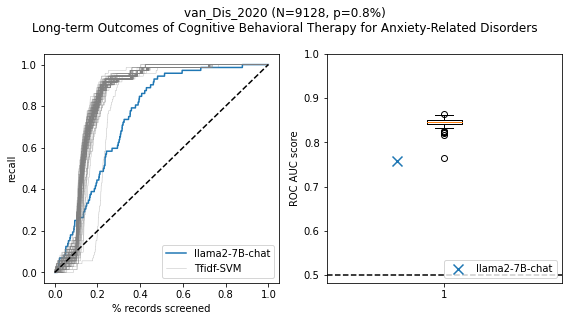

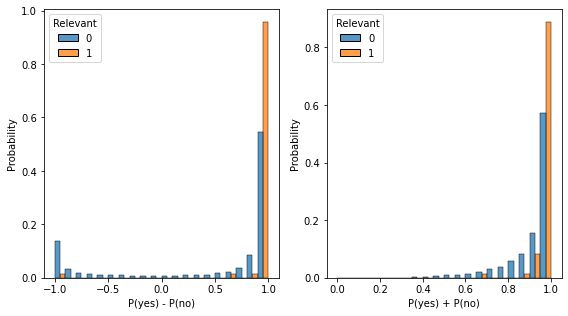

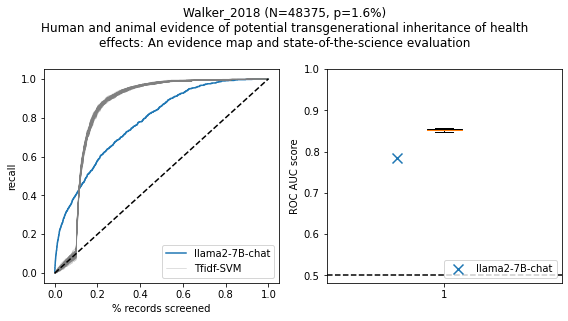

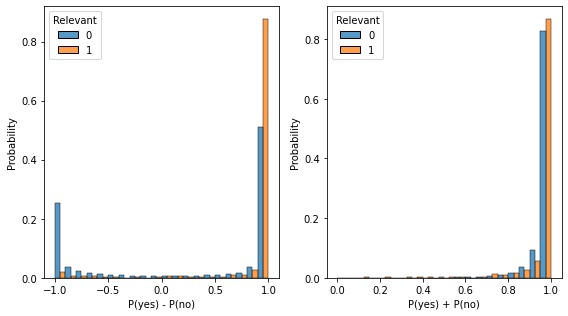

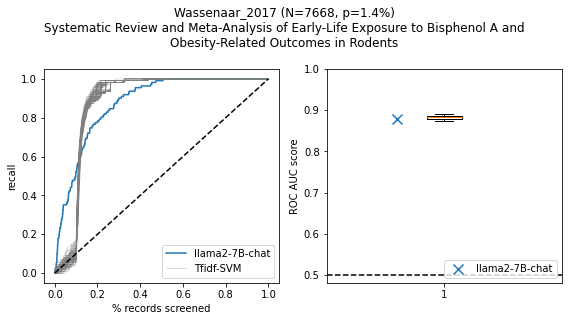

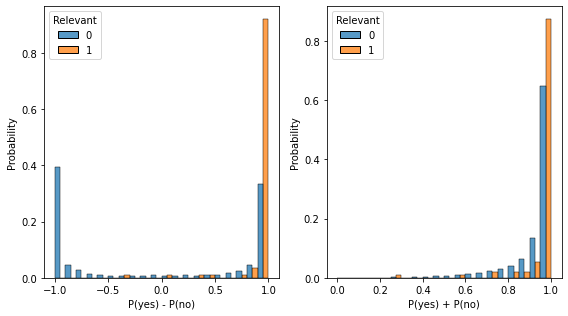

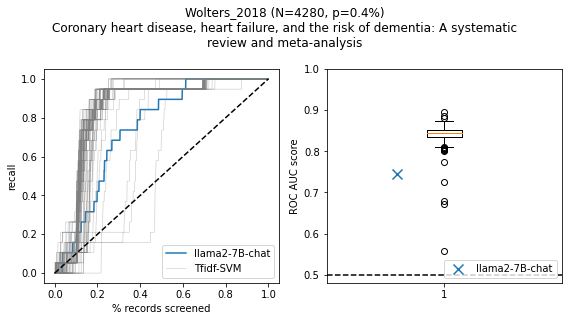

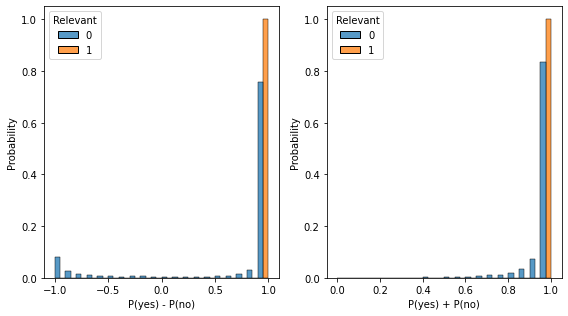

In [14]:

svm_auc_scores = []
llm_auc_scores = []
llm_alt_auc_scores = []
reviews = []

def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

for r, row in rdf.iterrows():
    table = pq.read_table(
        'output_data/ordered_records', 
        filters=[('review_id', '=', row['review_id'])]
    )
    
    review_name = row['review_name']
    llm_df = pd.read_csv(f'output_data/{review_name}_LLM.csv').dropna()

    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    ax = axs[0]
    
    # Plot LLM recall curve
    ax.plot(llm_df['x'], llm_df['recall'], label='llama2-7B-chat')
    
    
    study_title = f'{review_name} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review_name])
    
    #  Go through each active learning run, and plot progress
    aucs = []
    
    for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
    svm_auc_scores.append(aucs)
    
    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')
    
    ax.legend()
    
    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    # Calculate LLM ROC AUC score and plot it with an x
    auc = roc_auc_score(llm_df['y'], llm_df['pred'])
    llm_auc_scores.append(auc)
    alt_auc = roc_auc_score(llm_df['y'], llm_df['alt_pred'])
    llm_alt_auc_scores.append(alt_auc)
    axs[1].scatter(
        0.8, auc,     
        marker='x',
        s=100,
        zorder=50,
        label='llama2-7B-chat'
    )
    
    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
    plt.show()
    
    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')
    
    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    #plt.suptitle(study_title + '\n' + d_map[review])
    
    fig.tight_layout()
    plt.savefig(f'figures/{review_name}_p_distribution.pdf', bbox_inches='tight')
    plt.show()
    #break

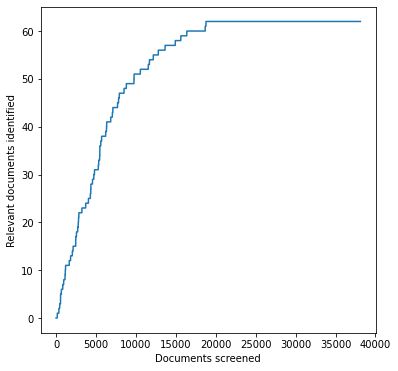

In [15]:
review = 'Brouwer_2019'
llm_df = pd.read_csv(f'output_data/{review}_LLM.csv').dropna()
fig, ax = plt.subplots(figsize=(6,6))


llm_df.sort_values('py', ascending=False).reset_index(drop=True).y.cumsum().plot()
ax.set_xlabel('Documents screened')
ax.set_ylabel('Relevant documents identified')

plt.savefig('figures/LLM_Brouwer_simple.pdf', bbox_inches='tight')

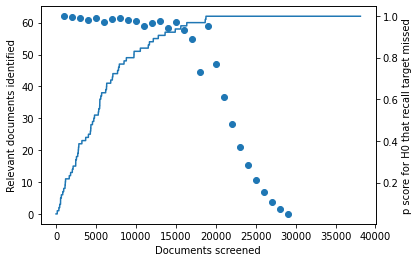

In [16]:
from buscarpy import retrospective_h0

y = llm_df.sort_values('py', ascending=False).reset_index(drop=True).y
h0 = retrospective_h0(y, llm_df.shape[0])

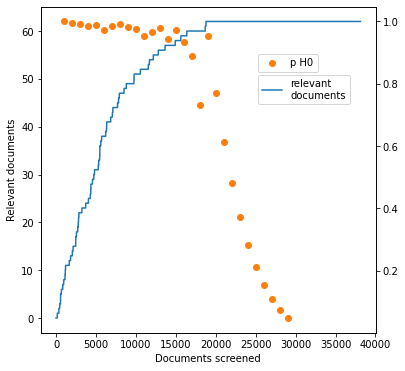

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y.cumsum(), label='relevant\ndocuments')

ax.set_ylabel('Relevant documents')

ax2 = ax.twinx()

ax2.scatter(h0['batch_sizes'], h0['p'], c='C1', label='p H0')

ax.legend(loc=(0.65,0.7))
ax2.legend(loc=(0.65, 0.8))
ax.set_xlabel('Documents screened')

plt.savefig('figures/stopping.pdf', bbox_inches='tight')

In [18]:
df

,review_id,Count(DISTINCT run_id)
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100
5,5,100
6,6,100
7,7,100
8,8,100
9,9,100


In [19]:
df.thread.unique()

AttributeError: 'DataFrame' object has no attribute 'thread'

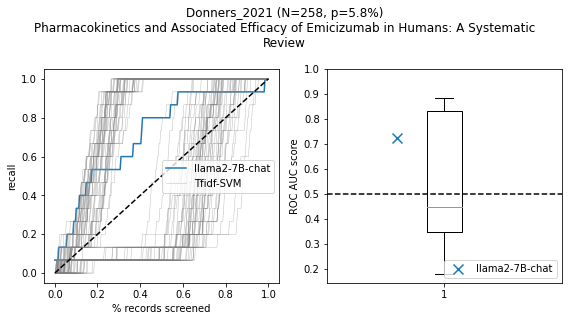

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

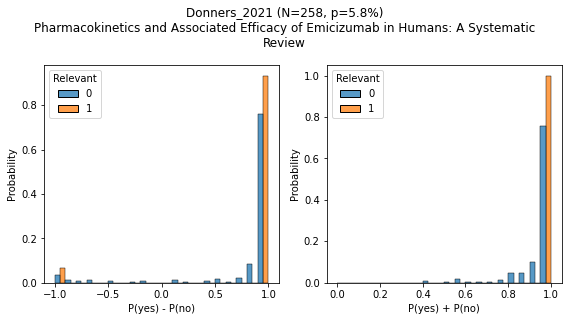

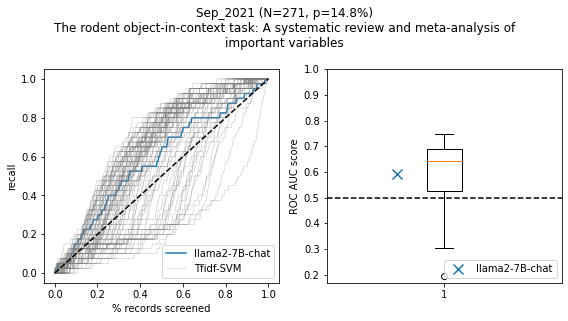

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

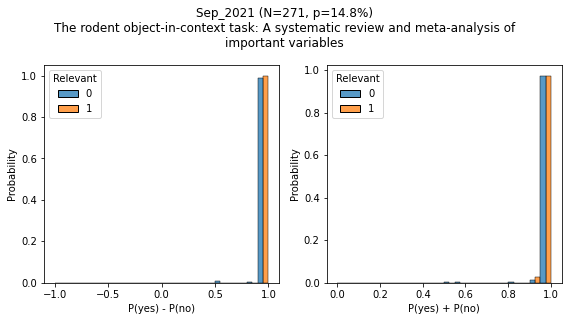

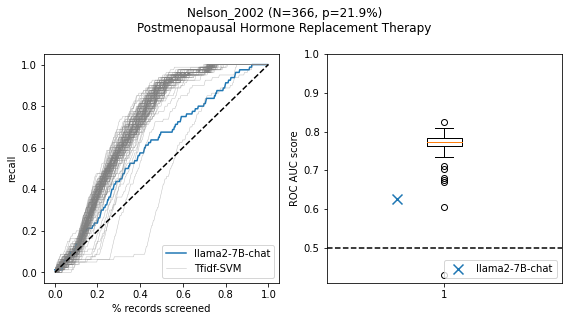

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

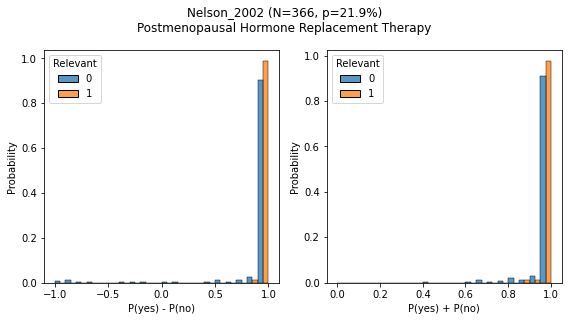

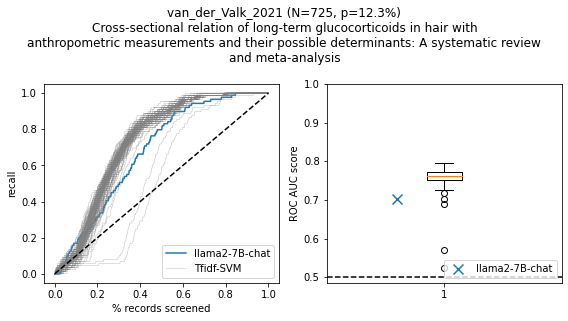

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

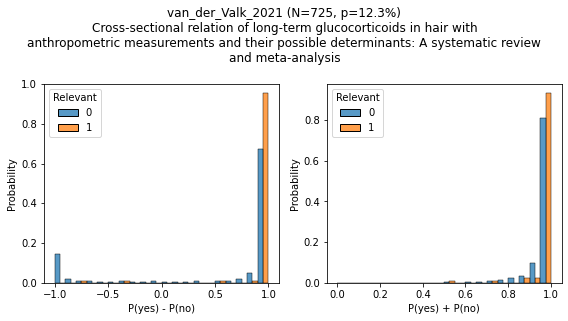

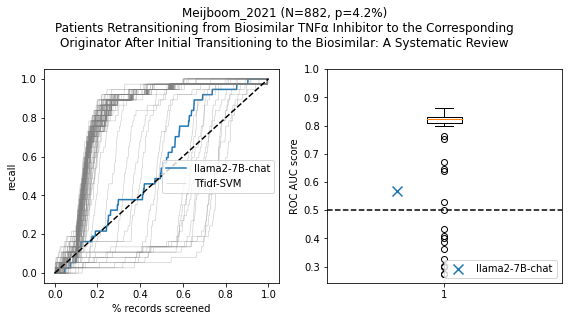

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

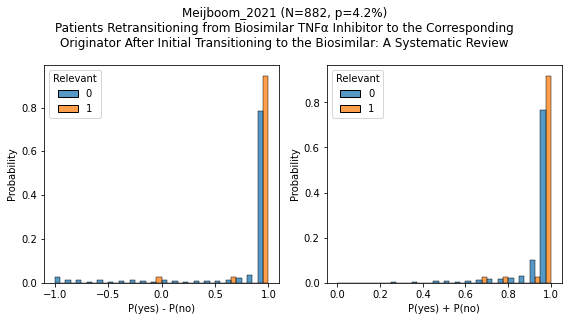

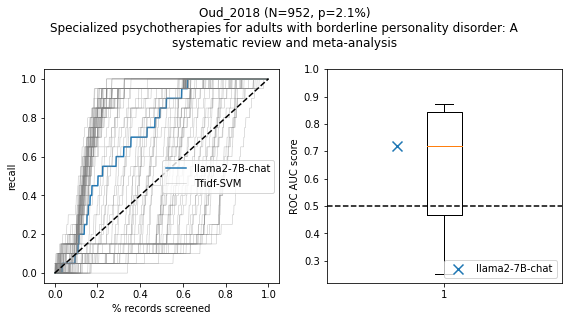

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

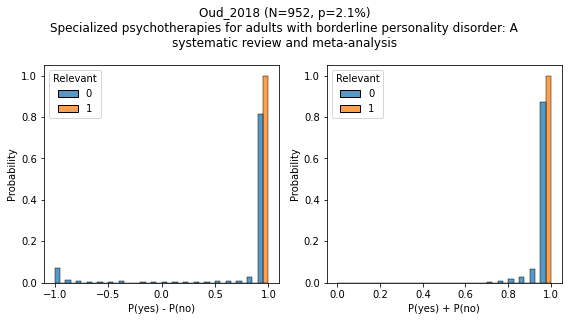

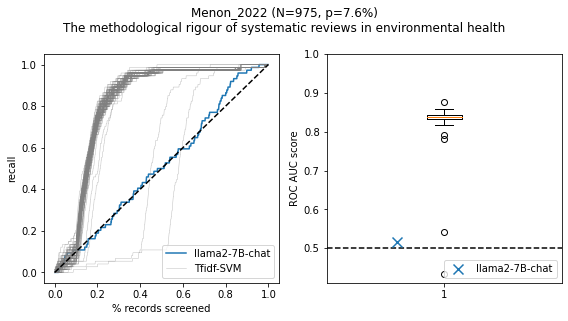

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

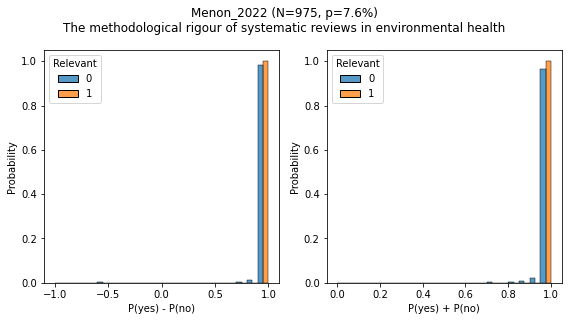

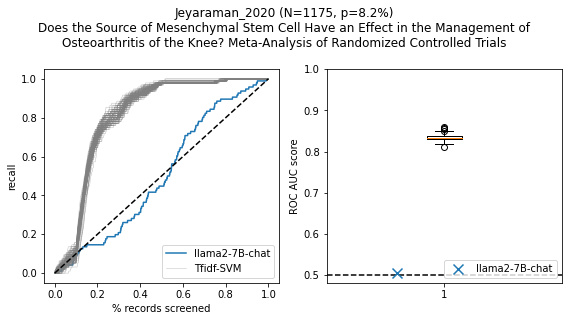

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

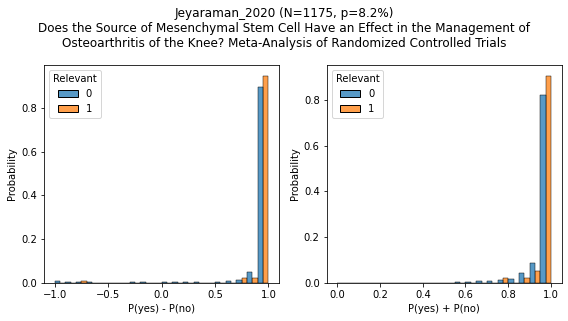

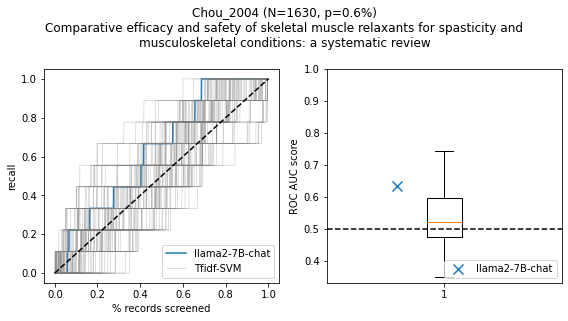

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

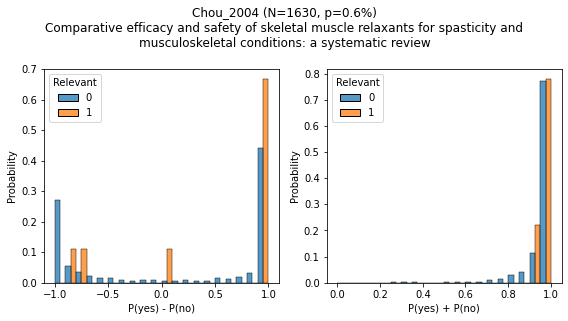

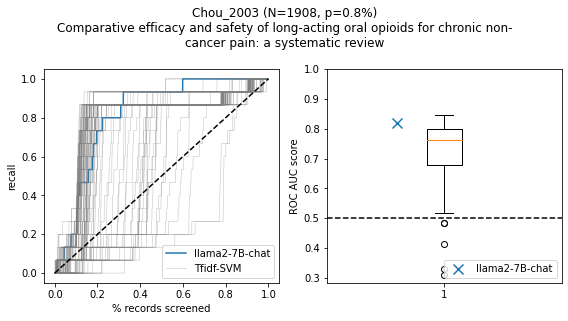

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

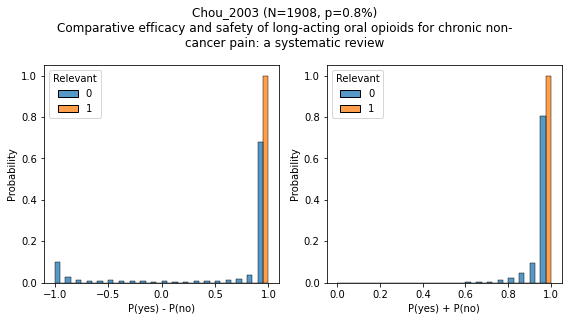

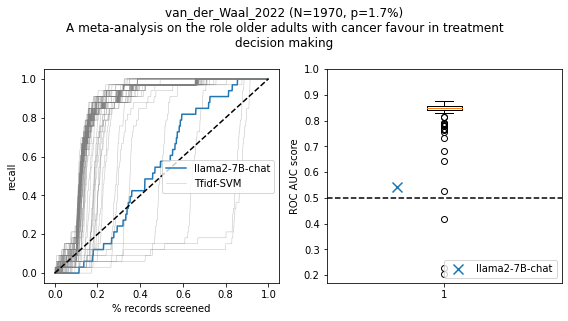

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

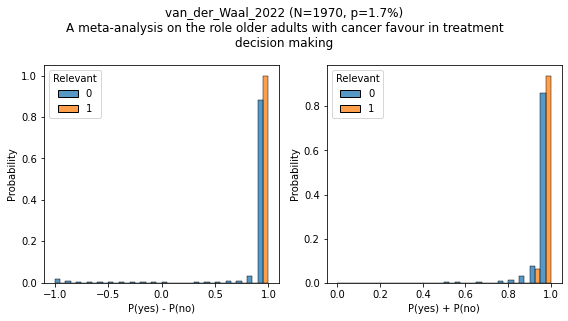

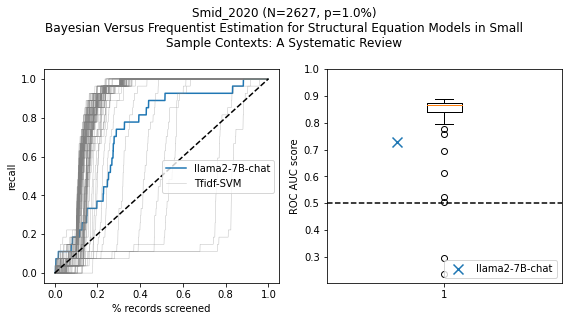

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

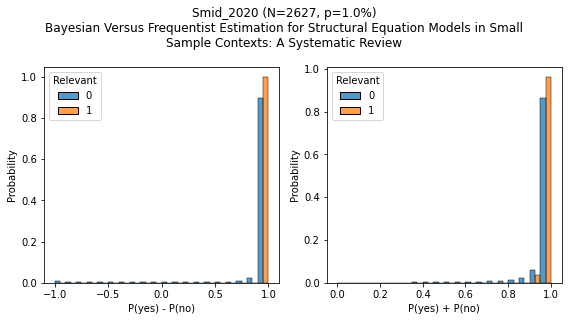

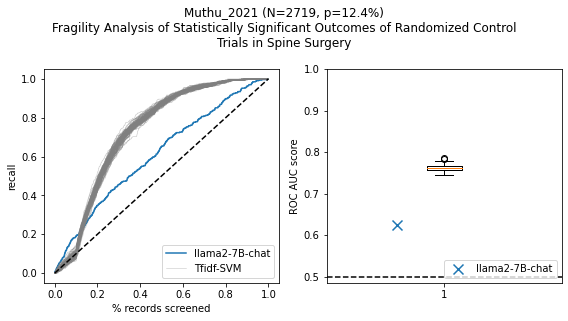

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

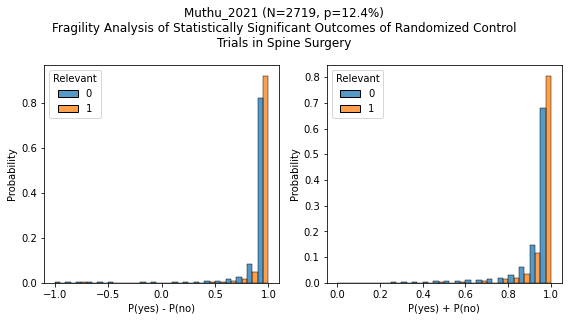

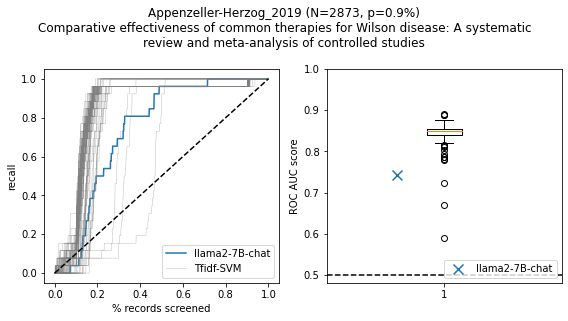

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

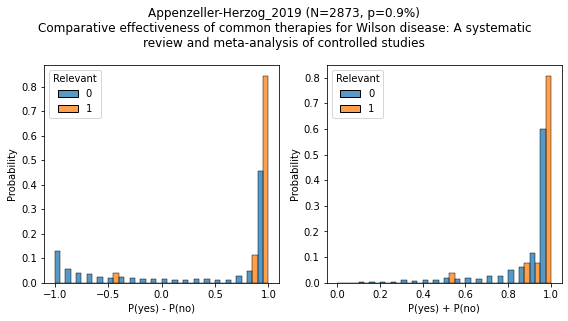

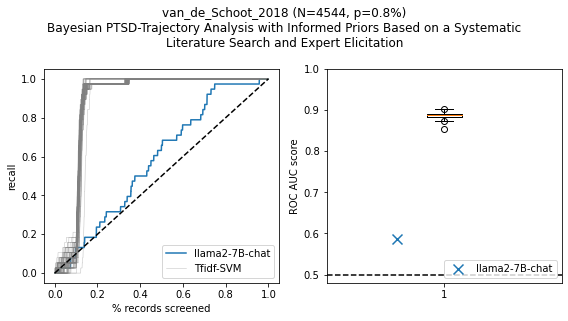

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

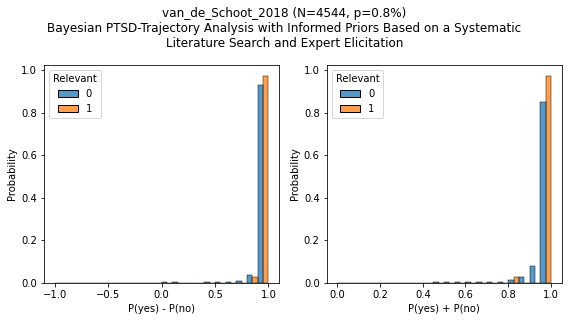

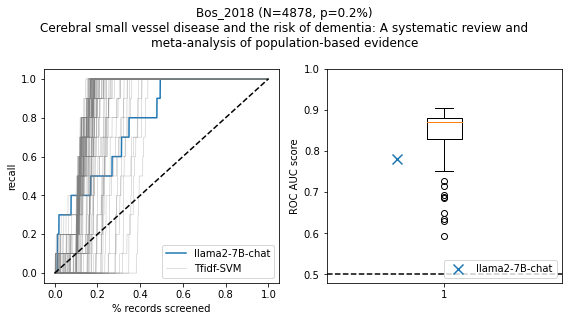

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

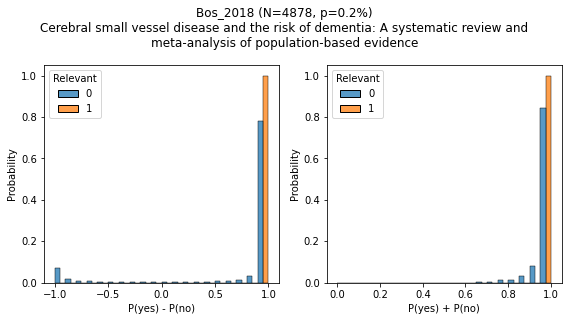

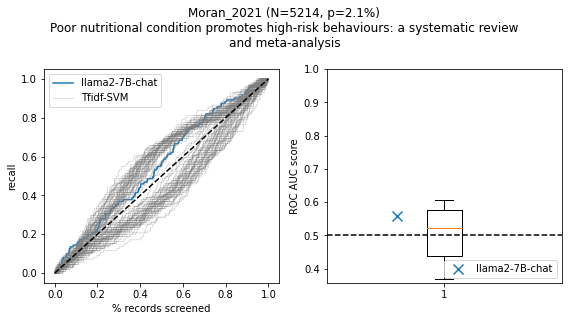

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

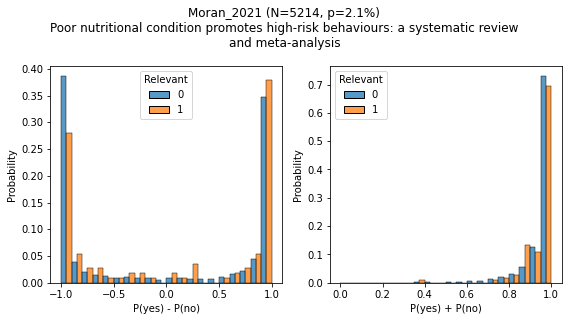

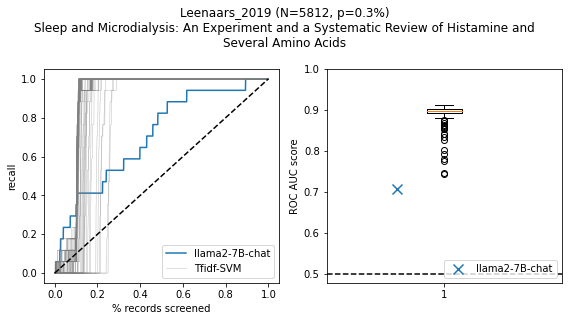

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

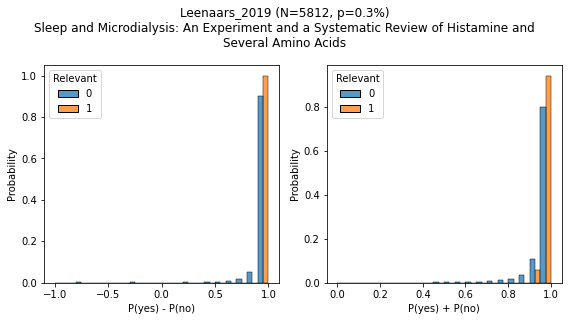

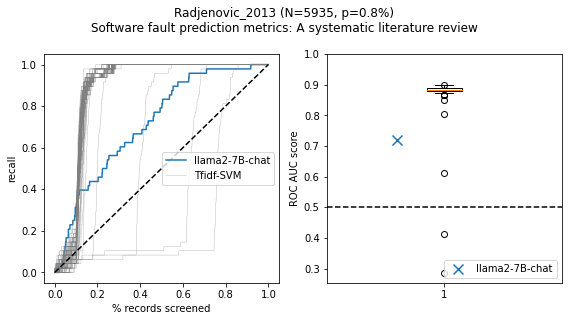

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

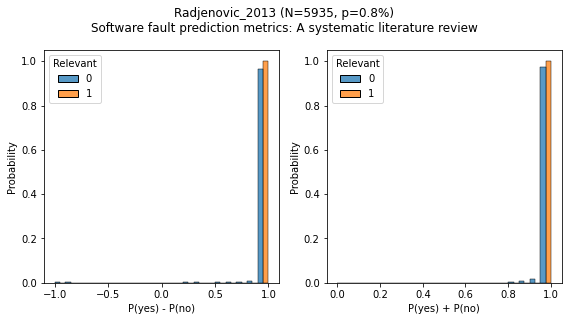

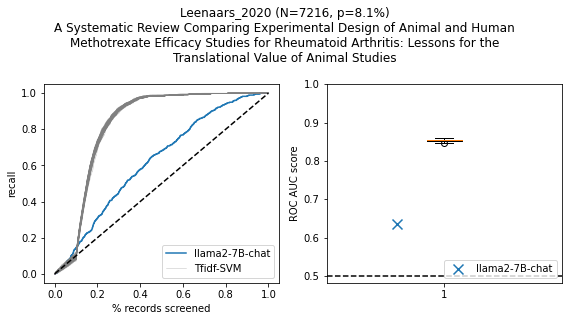

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

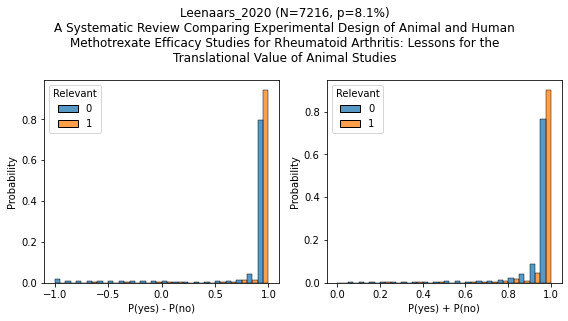

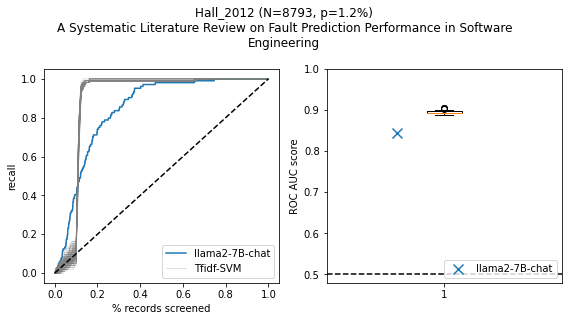

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

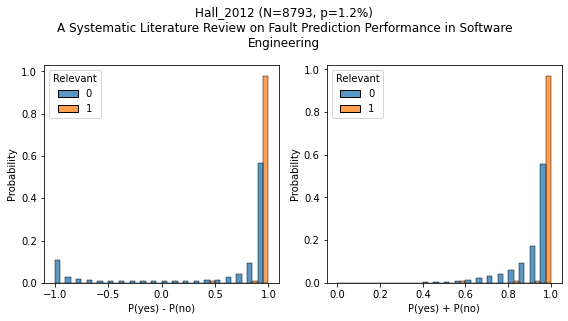

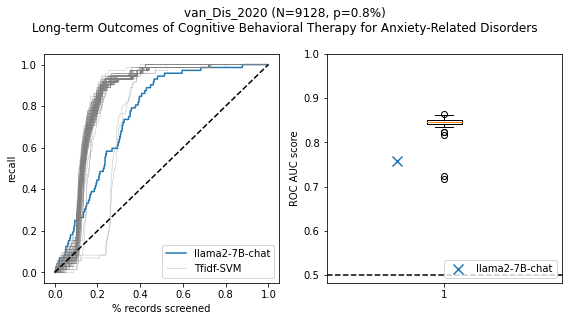

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

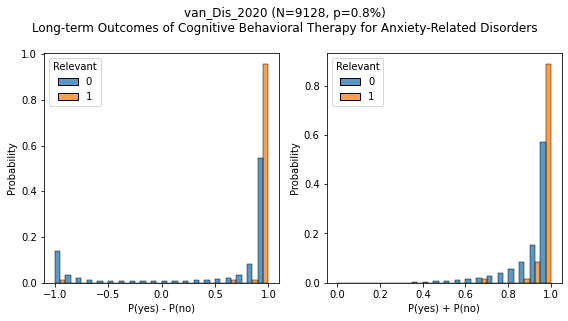

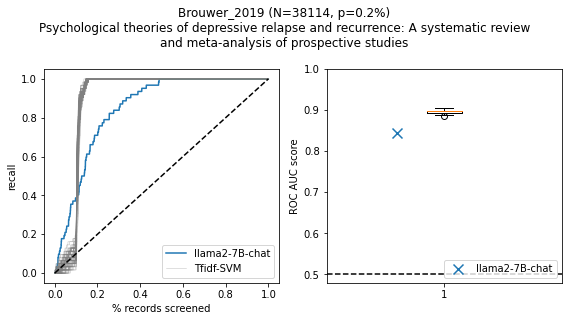

/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/max/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When groupin

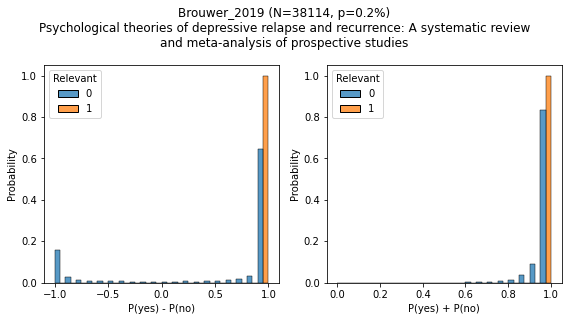

In [16]:
svm_auc_scores = []
llm_auc_scores = []
llm_alt_auc_scores = []
reviews = []

for i, row in df.groupby('review')['screened_order'].max().sort_values().reset_index().iterrows():
    review = row['review']
    rdf = df[df['review']==review]
    llm_df = pd.read_csv(f'output_data/{review}_LLM.csv').dropna()
    try:
        llm_df = pd.read_csv(f'output_data/{review}_LLM.csv').dropna()
    except:
        continue
    if llm_df.shape[0] < 5:
        continue
    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    ax = axs[0]
    
    # Plot LLM recall curve
    ax.plot(llm_df['x'], llm_df['recall'], label='llama2-7B-chat')
    
    study_title = f'{review} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review])
    
    #  Go through each active learning run, and plot progress
    aucs = []
    for i, (name, group) in enumerate(rdf.groupby('thread')):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
    svm_auc_scores.append(aucs)
    
    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')
    
    ax.legend()
    
    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    # Calculate LLM ROC AUC score and plot it with an x
    auc = roc_auc_score(llm_df['y'], llm_df['pred'])
    llm_auc_scores.append(auc)
    alt_auc = roc_auc_score(llm_df['y'], llm_df['alt_pred'])
    llm_alt_auc_scores.append(alt_auc)
    axs[1].scatter(
        0.8, auc,     
        marker='x',
        s=100,
        zorder=50,
        label='llama2-7B-chat'
    )
    
    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review}.pdf', bbox_inches='tight')
    plt.show()
    
    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')
    
    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    plt.suptitle(study_title + '\n' + d_map[review])
    
    fig.tight_layout()
    plt.savefig(f'figures/{review}_p_distribution.pdf', bbox_inches='tight')
    plt.show()


,run_id,rec_id,screened_order,first_prediction,last_prediction,review_id,relevant,thread
0,1,https://openalex.org/W2402226166,2617,0.005503,0.001191,1,0,0
1,1,https://openalex.org/W2416808666,1114,0.005221,0.005735,1,0,0
2,1,https://openalex.org/W2060266518,2749,0.005816,0.000913,1,0,0
3,1,https://openalex.org/W2412464989,1982,0.005227,0.002714,1,0,0
4,1,https://openalex.org/W66518910,2036,0.005629,0.002600,1,0,0
...,...,...,...,...,...,...,...,...
7746,1,https://openalex.org/W2335355989,8,NaN,NaN,2,0,0
7747,1,https://openalex.org/W2004693835,1444,0.001477,0.004204,2,0,0
7748,1,https://openalex.org/W2033437797,3887,0.001566,0.000783,2,0,0
7749,1,https://openalex.org/W2025852321,2838,0.001432,0.001035,2,0,0


In [40]:
    llm_df['pred'] = llm_df['py'] - llm_df['pn']
    llm_df['alt_pred'] = llm_df['py'] + (1-llm_df['pn'])

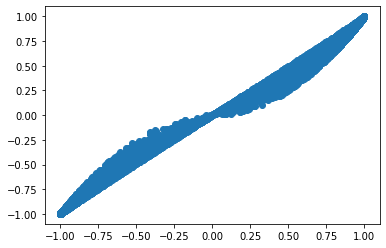

In [60]:
fig, ax = plt.subplots()

ax.scatter(llm_df['pred'], llm_df['alt_pred'])

Text(0, 0.5, 'P(yes)+(1-P(no))')

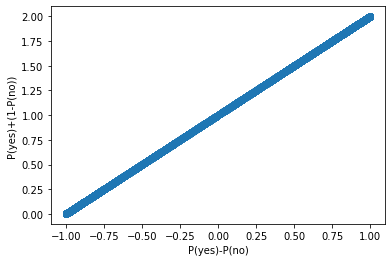

In [64]:
fig, ax = plt.subplots()

ax.scatter(llm_df['py']-llm_df['pn'], llm_df['py']+1-llm_df['pn'])

ax.set_xlabel('P(yes)-P(no)')
ax.set_ylabel('P(yes)+(1-P(no))')

Text(0, 0.5, '(P(yes)-(P(no))*(P(yes)+P(no))')

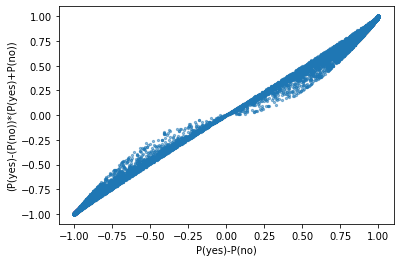

In [69]:
fig, ax = plt.subplots()

ax.scatter(
    llm_df['py']-llm_df['pn'], 
    (llm_df['py']-llm_df['pn'])*(llm_df['py']+llm_df['pn']),
    s=5, alpha=0.5
)

ax.set_xlabel('P(yes)-P(no)')
ax.set_ylabel('(P(yes)-(P(no))*(P(yes)+P(no))')

In [57]:
y = np.array([.4,.6])
n = np.array([.2,.4])
print(y-n)
print(y+1-n)
print((y-n)*(y+n))

[0.2 0.2]
[1.2 1.2]
[0.12 0.2 ]


In [55]:
(y-n)*(y+n)

array([0.12, 0.2 ])

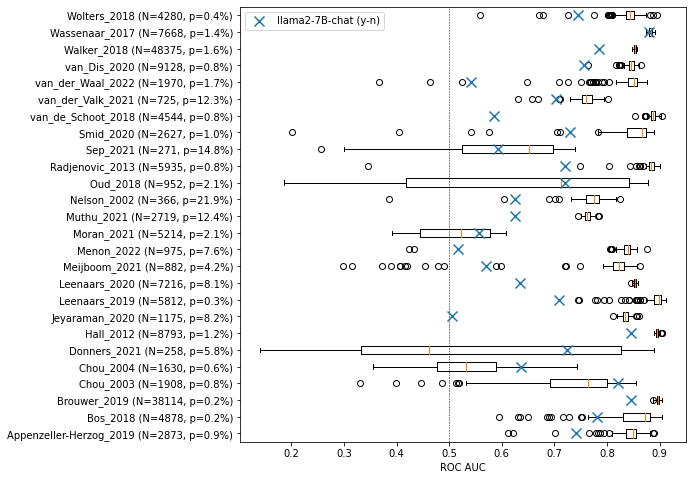

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
ax.scatter(
    llm_auc_scores, 
    np.arange(len(llm_auc_scores))+1,
    marker='x',
    s=100,
    zorder=50,
    label='llama2-7B-chat (y-n)'
)
# ax.scatter(
#     llm_alt_auc_scores, 
#     np.arange(len(llm_alt_auc_scores))+1,
#     marker='o',
#     s=100,
#     zorder=50,
#     color='none',
#     edgecolor='C1',
#     lw=2,
#     label='y + (1-n)'
# )
#sns.stripplot(svm_auc_scores, orient='h')
ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()

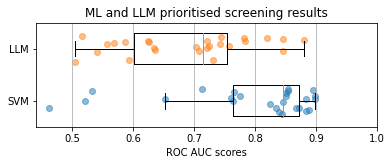

In [58]:
scaler = 1.5
fig, ax = plt.subplots(figsize=(3.7*scaler,1.6*scaler))
meds = [np.median(x) for x in svm_auc_scores]
ax.boxplot(
    [meds, llm_auc_scores],
    vert=False, widths=0.6, showfliers=False,
)
noise = (np.random.random(size=len(meds))-.5)/2
ax.scatter(
    meds, 1+noise,
    alpha=0.5
)

noise = (np.random.random(size=len(llm_auc_scores))-.5)/2
ax.scatter(
    llm_auc_scores, 2+noise,
    alpha=0.5
)
ax.set_yticklabels(['SVM','LLM'])

ax.set_xlabel('ROC AUC scores')
ax.set_title('ML and LLM prioritised screening results')
ax.grid(axis='x')
ax.set_xlim(xmax=1)

fig.tight_layout()

(array([1., 0., 1., 2., 2., 7., 5., 2., 2., 4.]),
 array([-0.26145405, -0.20242953, -0.14340501, -0.08438049, -0.02535598,
         0.03366854,  0.09269306,  0.15171757,  0.21074209,  0.26976661,
         0.32879113]),
 <BarContainer object of 10 artists>)

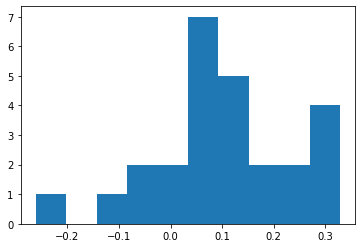

In [56]:
diff = np.array(meds) - np.array(llm_auc_scores) 

plt.hist(diff)

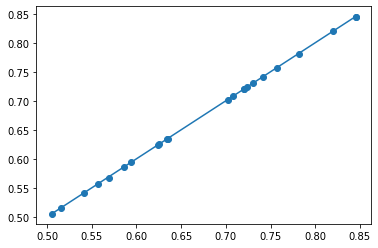

In [70]:
fig, ax = plt.subplots()

ax.scatter(llm_auc_scores, llm_alt_auc_scores)
mi, ma = min(llm_auc_scores), max(llm_auc_scores)

ax.plot([mi,ma], [mi,ma])

In [84]:
diff = (np.array(llm_alt_auc_scores) - np.array(llm_auc_scores)).mean()
sd = (np.array(llm_alt_auc_scores) - np.array(llm_auc_scores)).std()
f'{diff:.2%} ({sd:.2%})'

'-0.06% (0.07%)'

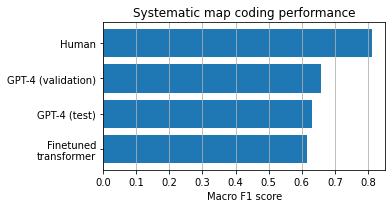

In [46]:
fig, ax = plt.subplots(figsize=(3.7*scaler,2*scaler))

ax.barh([0,1,2,3],[0.617,0.6296,0.6588,0.8116])
ax.grid(axis='x')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['Finetuned\ntransformer','GPT-4 (test)','GPT-4 (validation)','Human'])
ax.set_xlabel('Macro F1 score')
ax.set_title('Systematic map coding performance')

fig.tight_layout()


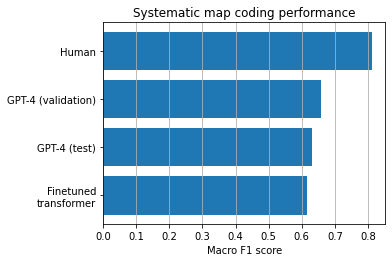

In [48]:
fig, ax = plt.subplots(figsize=(3.7*scaler,2.5*scaler))

ax.barh([0,1,2,3],[0.617,0.6296,0.6588,0.8116])
ax.grid(axis='x')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['Finetuned\ntransformer','GPT-4 (test)','GPT-4 (validation)','Human'])
ax.set_xlabel('Macro F1 score')
ax.set_title('Systematic map coding performance')

fig.tight_layout()
plt.savefig('figures/LLM-coding.pdf',bbox_inches='tight')